In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

2024-02-12 07:21:42.124833: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 07:21:42.124940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 07:21:42.391874: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data Preparation

batch_size = 64

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    '/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)



Found 8948 images belonging to 3 classes.
Found 557 images belonging to 3 classes.


In [5]:
checkpoint_dir = 'Custom_Model/'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define a ModelCheckpoint callback to save the model at every improved epoch
checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}_train_acc_{accuracy:.4f}_val_acc_{val_accuracy:.4f}.h5'),
    monitor='val_accuracy',  # metric to monitor
    verbose=1,  # verbosity - 0 or 1
    save_best_only=True,  # Save only the best model according to the monitored metric
    mode='max',  # Since we are monitoring accuracy, higher is better
    save_weights_only=False  # Save the full model, not just the weights
)

# Create a custom CNN model
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(256, 256, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Adding dropout for regularization
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Adding dropout for regularization
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Adding dropout for regularization
    Flatten(),
    Dense(128, activation='relu', name='fc1'),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(64, activation='relu', name='fc2'),
    Dense(3, activation='softmax')  # Assuming 3 classes
])
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])
model.summary()
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint],
    use_multiprocessing=True,  # Enable multiprocessing
    workers=6  # Number of workers to use. Adjust as per your CPU cores.
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 126, 126, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 64)      36928     
                                                        

2024-02-12 07:22:09.781074: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707722543.201408      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


140/140 [==============================] - ETA: 0s - loss: 0.9321 - accuracy: 0.5583 - f1_score: 0.4320
Epoch 1: val_accuracy improved from -inf to 0.54758, saving model to Custom_Model/model_epoch_01_train_acc_0.5583_val_acc_0.5476.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 145s 852ms/step - loss: 0.9321 - accuracy: 0.5583 - f1_score: 0.4320 - val_loss: 1.0594 - val_accuracy: 0.5476 - val_f1_score: 0.0000e+00
Epoch 2/50
140/140 [==============================] - ETA: 0s - loss: 0.8320 - accuracy: 0.6187 - f1_score: 0.5090
Epoch 2: val_accuracy improved from 0.54758 to 0.58169, saving model to Custom_Model/model_epoch_02_train_acc_0.6187_val_acc_0.5817.h5
140/140 [==============================] - 105s 726ms/step - loss: 0.8320 - accuracy: 0.6187 - f1_score: 0.5090 - val_loss: 0.9541 - val_accuracy: 0.5817 - val_f1_score: 0.4544
Epoch 3/50
140/140 [==============================] - ETA: 0s - loss: 0.7608 - accuracy: 0.6499 - f1_score: 0.5571
Epoch 3: val_accuracy improved from 0.58169 to 0.61939, saving model to Custom_Model/model_epoch_03_train_acc_0.6499_val_acc_0.6194.h5
140/140 [==============================] - 105s 722ms/step - loss: 0.7608 - accuracy: 0.6499 - f1_score: 0.5571 - val_loss: 0.8981 - val_accur

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 126, 126, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 64)      36928     
                                                        

In [7]:
import numpy as np # linear algebra
from tensorflow import keras
import tensorflow as tf
from scipy import ndimage as image_filter
from PIL import Image
import os

APPLY_MASK=False
APPLY_FILTER=False
!mkdir -p "/kaggle/temp"
#Get a tf.data.Dataset with out pre processed images
def get_dataset(base, variant):
	path = os.path.join(base, variant)
	#Classes order
	classes = ["Normal", "COVID-19", "Non-COVID"]
	paths = tf.data.Dataset.list_files(path + "/*/images/*.png", seed=123, name=variant)
	def mask_path_and_label(file_name):
		label_str = tf.strings.split(file_name, "/")[-3]
		mask_path = tf.strings.regex_replace(file_name, "/images/", "/lung masks/")
		label = classes.index(label_str)
		return file_name, mask_path, label
	def load(image_path, mask_path, label):
		def path_to_image(path):
			file = tf.io.read_file(path)
			img = tf.io.decode_png(file, channels=1)
			return tf.image.resize(img, [256, 256])
		image = path_to_image(image_path)
		mask = path_to_image(mask_path)
		return image, mask, label
	def tf_mask_label(file_name):
		image, mask, label = tf.py_function(mask_path_and_label, [file_name], [tf.string, tf.string, tf.uint8])
		image.set_shape(tf.TensorShape([]))
		mask.set_shape(tf.TensorShape([]))
		label.set_shape(tf.TensorShape([]))
		return image, mask, label
	def process_image(image, mask, label):
		image = tf.math.divide(image, 255)
		if not APPLY_MASK:
			return image, label
		mask = tf.math.divide(mask, 255)
		masked = tf.math.multiply(image, mask)
		return masked, label
	def onehot(img, label):
		return img, tf.one_hot(label, depth=len(classes))
	print(paths.cardinality().numpy(), "files on dataset", variant)
	dataset = paths.map(tf_mask_label).map(load,
						num_parallel_calls=32
					).map(process_image,
						num_parallel_calls=tf.data.AUTOTUNE
					).map(onehot)
	cache_prefix = ""
	if APPLY_FILTER:
		cache_prefix += "sobel_"
		def py_filter(image):
			filtered = image_filter.sobel(image, axis=1)
			return filtered
		def tf_py_filter(image, label):
			[filtered] = tf.py_function(py_filter, [image], [tf.float32])
			filtered.set_shape(image.shape)
			return filtered, label
		dataset = dataset.map(tf_py_filter)
	if not APPLY_MASK:
		cache_prefix += "unmasked_"
	dataset = dataset.cache(os.path.join("/kaggle/temp", cache_prefix + variant))
	dataset = dataset.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
	dataset.class_names = classes
	return dataset

# Return a tupple with three datasets (train, val, test)
# Images are masked
def get_all_datasets(base):
	test = get_dataset(base, "Test")
	val = get_dataset(base, "Val")
	train = get_dataset(base, "Train")
	return (train, val, test)
	
train, val, test = get_all_datasets("/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data")
#Helps with cache
val = val.shuffle(val.cardinality().numpy(), seed=0)
val.class_names = train.class_names
test = test.shuffle(test.cardinality().numpy(), seed=0, reshuffle_each_iteration=False)
test.class_names = train.class_names

1166 files on dataset Test
932 files on dataset Val
3728 files on dataset Train


In [8]:
#Takes a dataset and splits it into two, one with binary output for normal/not-normal, second with covid/non-covid
def split_dataset(dataset, balanced=False):
	batch_size = dataset.element_spec[0].shape[0]

	def binary_good(dataset):
		def drop_half_disease(dataset):
			counter = tf.data.Dataset.counter()
			unbatch = dataset.unbatch()
			with_counter =tf.data.Dataset.zip((unbatch, counter))
			def filter(image_label, count):
				label = image_label[1]
				is_disease = label[0] == 1
				is_even = count % 2 == 0
				return (is_disease and is_even) or not is_disease
			return with_counter.filter(filter).map(lambda image_label, count: (image_label[0], image_label[1])).batch(batch_size, drop_remainder=True)
		
		def transform_onehot_to_binary(image, label):
				normal = tf.gather(label, [0], axis=1)
				normal = tf.cast(normal, dtype=tf.uint8)
				return image, tf.squeeze(tf.one_hot(normal, depth=2))
		
		dataset = dataset.map(transform_onehot_to_binary)
		if balanced:
			dataset = dataset.apply(drop_half_disease)
		dataset.class_names = ["Ill", "Normal"]
		return dataset
	
	def binary_disease(dataset):
		def filter_normal(image, label):
			normal = tf.unstack(label)[0]
			return tf.equal(normal, 0)
		
		def remove_normal(image, label):
			disease = tf.gather(label, [1, 2], axis=1)
			return image, disease
		
		classes = dataset.class_names
		filtered = dataset.unbatch().filter(filter_normal).batch(batch_size, drop_remainder=True)
		dataset = filtered.map(remove_normal)
		dataset.class_names = classes[1:]
		return dataset
	
	return (dataset.apply(binary_good), dataset.apply(binary_disease))
print(split_dataset(train))

(<_MapDataset element_spec=(TensorSpec(shape=(32, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(32, 2), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(32, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(32, 2), dtype=tf.float32, name=None))>)


In [9]:
LEARNING_RATE_NORMAL = 0.0001
LEARNING_RATE_DISEASE = 0.00001
EARLY_STOP=3
EPOCHS=5
SEED = 1234
keras.utils.set_random_seed(SEED)
HID_ACTIVATION = keras.activations.relu
OUT_ACTIVATION = keras.activations.softmax
LOSS = keras.losses.CategoricalCrossentropy(from_logits=False)
REGULARIZER = keras.regularizers.l2(0.00001)
INITIALIZER = keras.initializers.HeUniform(np.random.randint(2**62))
NORMAL_LAYERS = [880, 464]
DISEASE_LAYERS = [1120, 832, 384]

def make_models_parametrized(normal_layers, disease_layers):
	def input_model():
		model = keras.Sequential(name="input_map")
		model.add(keras.layers.Input((256,256, 1)))
		model.add(keras.layers.Normalization())
		model.add(keras.layers.AveragePooling2D((2, 2)))
		model.add(keras.layers.Flatten())
		return model

	def normal_model(layers):
		model = keras.Sequential(name="normal_classifier")
		for units in layers:
			model.add(keras.layers.Dense(
					units=units,
					activation=HID_ACTIVATION,
					kernel_initializer=INITIALIZER,
					kernel_regularizer=REGULARIZER,
				))
			model.add(keras.layers.Normalization())
		model.add(keras.layers.Dense(units=2, activation=OUT_ACTIVATION))
		return model

	def disease_model(layers):
		model = keras.Sequential(name="disease_classifier")
		for units in layers:
			model.add(keras.layers.Dense(
					units=units,
					activation=HID_ACTIVATION,
					kernel_initializer=INITIALIZER,
					kernel_regularizer=REGULARIZER,
				))
			model.add(keras.layers.Normalization())
		model.add(keras.layers.Dense(units=2, activation=OUT_ACTIVATION))
		return model

	input = keras.Input(shape=(256,256,1), name="0-1_normalized_image")
	input_filter = input_model()
	processed_input = input_filter(input)
	
	normal = normal_model(normal_layers)
	normal_output = normal(processed_input)

	disease = disease_model(disease_layers)
	disease_output = disease(processed_input)

	full_normal_model = keras.models.Model(input, normal_output, name="full_normal_classifier")
	full_disease_model = keras.models.Model(input, disease_output, name="full_disease_classifier")
	
	full_normal_model.compile(
		optimizer=keras.optimizers.RMSprop(LEARNING_RATE_NORMAL),
		loss=LOSS,
		metrics=[
			keras.metrics.CategoricalCrossentropy(
				name='categorical_crossentropy'),
			"accuracy",
		])
	full_disease_model.compile(
		optimizer=keras.optimizers.RMSprop(LEARNING_RATE_DISEASE),
		loss=LOSS,
		metrics=[
			keras.metrics.CategoricalCrossentropy(
				name='categorical_crossentropy'),
			"accuracy",
		])
	
	return (full_normal_model, full_disease_model)

def merge(normal, disease):
	normal_layer = normal.layers[-1]
	disease_layer = disease.layers[-1]

	input = normal.input
	pre_layer = normal.layers[1](input)
	normal_output = normal_layer(pre_layer)
	disease_output = disease_layer(pre_layer)
	concat = keras.layers.Concatenate(name="merge")([normal_output, disease_output])
	out = keras.layers.Dense(units=3, activation=OUT_ACTIVATION, name="merge_out")(concat)

	model = keras.models.Model(input, out, name="full_classifier")
	for layer in model.layers[:-1]:
		layer.trainable = False
	model.summary()
	model.compile(loss=LOSS, metrics=["accuracy", "categorical_crossentropy"])
	return model

def make_models():
	return make_models_parametrized(NORMAL_LAYERS, DISEASE_LAYERS)

normal_model, disease_model = make_models()
normal_model.summary()
disease_model.summary()

Model: "full_normal_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 0-1_normalized_image (Inpu  [(None, 256, 256, 1)]     0         
 tLayer)                                                         
                                                                 
 input_map (Sequential)      (None, 16384)             3         
                                                                 
 normal_classifier (Sequent  (None, 2)                 14831204  
 ial)                                                            
                                                                 
Total params: 14831207 (56.58 MB)
Trainable params: 14828514 (56.57 MB)
Non-trainable params: 2693 (10.53 KB)
_________________________________________________________________
Model: "full_disease_classifier"
_________________________________________________________________
 Layer (type)                Outp

In [10]:
early_stop = keras.callbacks.EarlyStopping(monitor="val_categorical_crossentropy", patience=EARLY_STOP, restore_best_weights=True)

train_normal, train_sick = split_dataset(train, True)
val_normal, val_sick = split_dataset(val)
normal_model.fit(train_normal,
		  epochs=EPOCHS,
		  validation_data=val_normal,
		  callbacks=[early_stop]
		)

disease_model.fit(train_sick,
		  epochs=EPOCHS,
		  validation_data=val_sick,
		  callbacks=[early_stop]
		)

Epoch 1/5
72/72 [==============================] - 40s 538ms/step - loss: 1.3379 - categorical_crossentropy: 1.3110 - accuracy: 0.5807 - val_loss: 0.5287 - val_categorical_crossentropy: 0.5018 - val_accuracy: 0.7586
Epoch 2/5
72/72 [==============================] - 1s 19ms/step - loss: 0.6903 - categorical_crossentropy: 0.6635 - accuracy: 0.6593 - val_loss: 0.4914 - val_categorical_crossentropy: 0.4645 - val_accuracy: 0.7791
Epoch 3/5
72/72 [==============================] - 1s 19ms/step - loss: 0.6255 - categorical_crossentropy: 0.5987 - accuracy: 0.6966 - val_loss: 0.5202 - val_categorical_crossentropy: 0.4934 - val_accuracy: 0.7575
Epoch 4/5
72/72 [==============================] - 1s 19ms/step - loss: 0.6037 - categorical_crossentropy: 0.5769 - accuracy: 0.7131 - val_loss: 0.4674 - val_categorical_crossentropy: 0.4406 - val_accuracy: 0.8093
Epoch 5/5
72/72 [==============================] - 1s 19ms/step - loss: 0.5555 - categorical_crossentropy: 0.5286 - accuracy: 0.7352 - val_los

In [11]:
model = merge(normal_model, disease_model)
model.fit(train, epochs=5, validation_data=val.shuffle(val.cardinality().numpy(), seed=0), callbacks=[early_stop])

Model: "full_classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 0-1_normalized_image (Inpu  [(None, 256, 256, 1)]        0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_map (Sequential)      (None, 16384)                3         ['0-1_normalized_image[0][0]']
                                                                                                  
 normal_classifier (Sequent  (None, 2)                    1483120   ['input_map[1][0]']           
 ial)                                                     4                                       
                                                                                    

In [12]:
from matplotlib import pyplot as plt
#Plot confusion matrix
def plot_confusion_matrix(confusion_matrix, labels):
	mat = confusion_matrix
	gridspec_kw = {"wspace": 0, "hspace": 0}
	subplot_kw = {"xticks": [], "yticks": []}
	center_text= {"horizontalalignment": "center", "verticalalignment": "center"}
	fig, axs = plt.subplots(nrows=mat.shape[0]+1, ncols=mat.shape[1]+1, sharex=True, sharey=True, gridspec_kw=gridspec_kw, subplot_kw=subplot_kw, figsize=(6, 6))
	for idx in range(mat.shape[0]):
		for jdx in range(mat.shape[1]):
			axs[idx,jdx].text(0.5, 0.6, mat[idx][jdx], **center_text, color="black", fontweight="bold")
			percentage = "{:.02f}%".format(mat[idx][jdx]/mat.sum()*100)
			axs[idx,jdx].text(0.5, 0.4, percentage, **center_text, color="black")
			if idx == jdx:
				axs[idx,jdx].set_facecolor("xkcd:sea green")
			else:
				axs[idx,jdx].set_facecolor("xkcd:salmon")

	#Plot precision
	for idx in range(mat.shape[0]):
		precision = mat[idx][idx]/mat.sum(axis=1)[idx]*100
		positive = "{:.02f}%".format(precision)
		negative = "{:.02f}%".format(100-precision)
		axs[idx, mat.shape[1]].text(0.5, 0.6, positive, **center_text, color="green")
		axs[idx, mat.shape[1]].text(0.5, 0.4, negative, **center_text, color="red")
		axs[idx, mat.shape[1]].set_facecolor("xkcd:grey")

	#Plot sensitivity
	for jdx in range(mat.shape[1]):
		sensitivity = mat[jdx][jdx]/mat.sum(axis=0)[jdx]*100
		positive = "{:.02f}%".format(sensitivity)
		negative = "{:.02f}%".format(100-sensitivity)
		axs[mat.shape[0], jdx].text(0.5, 0.6, positive, **center_text, color="green")
		axs[mat.shape[0], jdx].text(0.5, 0.4, negative, **center_text, color="red")
		axs[mat.shape[0], jdx].set_facecolor("xkcd:grey")


	accuracy = mat.diagonal().sum()/mat.sum()*100
	positive = "{:.2f}%".format(accuracy)
	negative = "{:.2f}%".format(100-accuracy)
	axs[mat.shape[0], mat.shape[1]].text(0.5, 0.6, positive, **center_text, color="darkgreen")
	axs[mat.shape[0], mat.shape[1]].text(0.5, 0.4, negative, **center_text, color="red")
	axs[mat.shape[0], mat.shape[1]].set_facecolor("xkcd:periwinkle blue")

	for idx in range(len(labels)):
		axs[idx, 0].set_ylabel(labels[idx])
		axs[0, idx].set_xlabel(labels[idx])
		axs[0, idx].xaxis.set_label_position("top")
	fig.supylabel("True label")
	fig.supxlabel("Predicted label")
	return fig

26/26 [==============================] - 0s 6ms/step


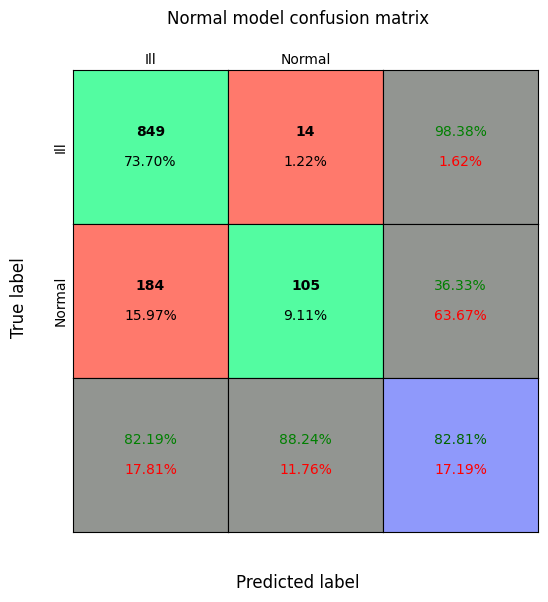

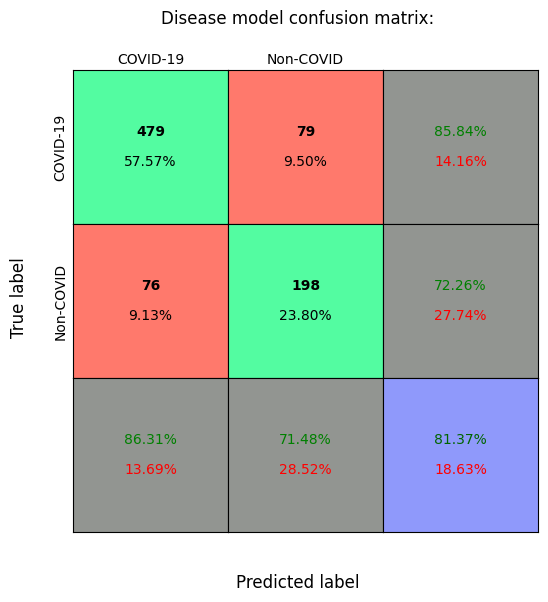

In [13]:
from sklearn.metrics import confusion_matrix
def evaluate(model: keras.Model, input):
	pred = model.predict(input.map(lambda image, _: image))
	target = np.concatenate(list(input.map(lambda _, target: target).as_numpy_iterator()))
	y_pred = np.argmax(pred, axis=1)
	y_targ = np.argmax(target, axis=1)
	confusion = confusion_matrix(y_targ, y_pred)
	return plot_confusion_matrix(confusion, input.class_names)

def evaluate_each(normal, disease, input):
	test_normal, test_disease = split_dataset(input)
	normal_fig = evaluate(normal, test_normal)
	normal_fig.savefig("normal.png")
	normal_fig.suptitle("Normal model confusion matrix")
	disease_fig = evaluate(disease, test_disease)
	disease_fig.savefig("disease.png")
	disease_fig.suptitle("Disease model confusion matrix:")
	plt.show()


evaluate_each(normal_model, disease_model, test)

36/36 [==============================] - 1s 6ms/step


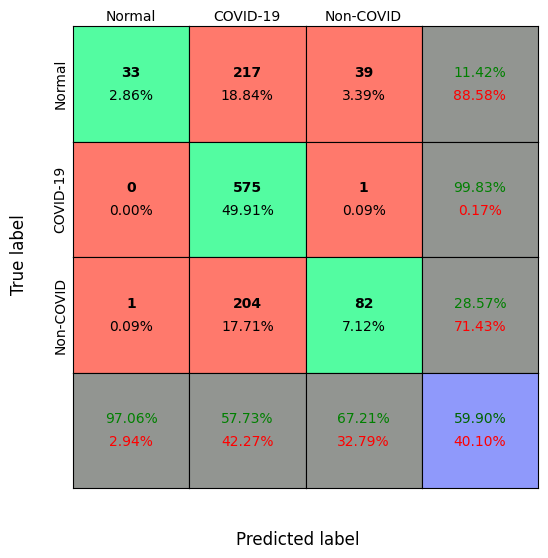

In [14]:
evaluate(model, test).savefig("complete.png")

In [15]:
#Save models
normal_model.save("/kaggle/working/normal_model.keras")
disease_model.save("/kaggle/working/disease_model.keras")
model.save("/kaggle/working/model.keras")

<Figure size 640x480 with 0 Axes>

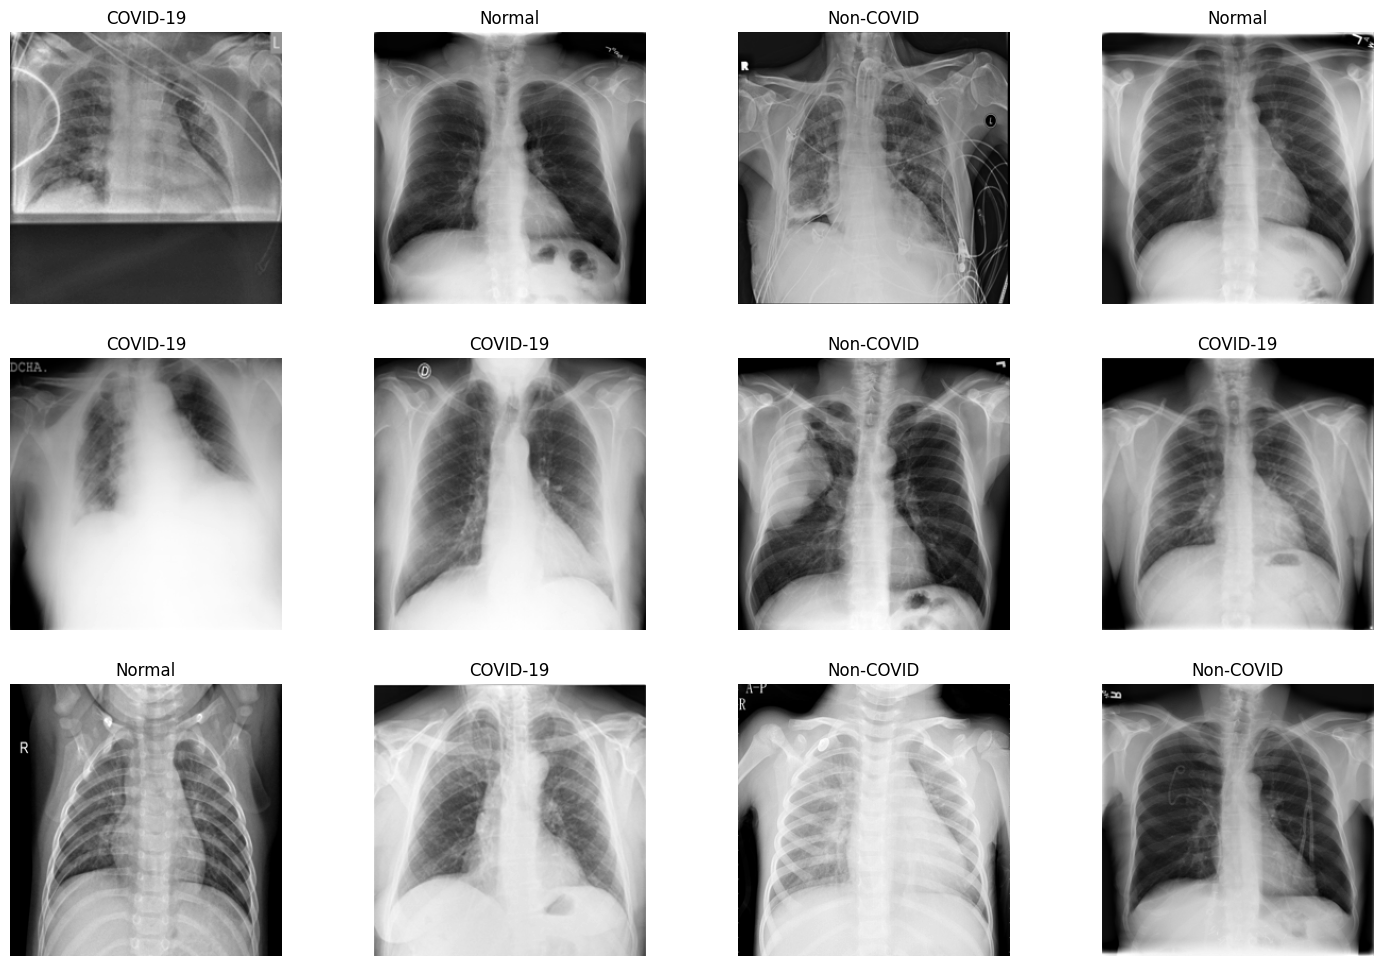

In [16]:
#Display some samples from train dataset
import matplotlib.pyplot as plt
dataset = train
plt.gray()
plt.figure(figsize=(18, 12))
for images, labels in dataset.take(1):
	labels = np.argmax(labels, 1)
	for i in range(12):
		img = images[i].numpy()[:, :, 0]
		ax = plt.subplot(3, 4, i + 1)
		plt.imshow(img)
		plt.title(dataset.class_names[labels[i]])
		plt.axis("off")
	plt.show()